This is an implementation to detect Copy move forgery detection using DBSCAN clustering to give you an idea for how to work with forgery detection using OpenCV and sklearn. This technique can be used to detect a forgery in many cases. However, the detection accuracy is not the best and can be improved further by other techniques.

## How to use cv2.xfeatures2d.SIFT_create() ?
SIFT features extraction is moved from OpenCV as SIFT is patented. I have downgraded OpenCV to use SIFT function in opencv.

In [45]:
#!pip uninstall opencv-python -y
#downgrade OpenCV a bit since some none-free features are not avilable
#!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

## About Dataset
The dataset used is taken from here [MICC](http://http://lci.micc.unifi.it/labd/2015/01/copy-move-forgery-detection-and-localization/) ("I. Amerini, L. Ballan, R. Caldelli, A. Del Bimbo, G. Serra. “A SIFT-based forensic method for copy-move attack detection and transformation recovery”, IEEE Transactions on Information Forensics and Security, vol. 6, issue 3, pp. 1099-1110, 2011.")

I have used MICC-F220 version which is composed of around 220 images; 110 are tampered and 110 originals.




In [46]:
#import libraries 
import os
import cv2
import matplotlib.pyplot as plt
import re
from sklearn.cluster import DBSCAN  # For DBSCAN
import numpy as np
%matplotlib inline

image_paths=[] #List to store path of all images

for dirname, _, filenames in os.walk('../Dataset/MICC-F220'):
    for filename in filenames:
        if '.txt' in filename:
            continue
        image_paths.append(os.path.join(dirname, filename))

## Dividing Into Tampered and Original
Here, I have divided image lists into tampered and original to use later.

In [47]:
original_images=[]
tampered_images=[]

for path in image_paths:
    
    if 'tamp' in path:              # As Observed from the above list tampered images name has tamp
        tampered_images.append(path)
    else:
        original_images.append(path)
tampered_images.sort()
original_images.sort()
print(len(original_images),len(tampered_images))

110 110


## Helper Functions

* **plot_image(img,size=(30,30))**: For plotting image.
* **siftDetector(img)**: For extracting SIFT features and descriptors.
* **get_original(tampered)**: Give the index of original image with the original image from the name of tampered image if present otherwise return -1.
* **show_sift_features(color_img, kp,size=(30,30),flag=None)**:  It marks the extracted features on the image and parameters are the image itself, kp are the SIFT keypoints and.

In [48]:
def plot_image(img,size=(8,8)):
    plt.figure(figsize = size)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)) #Since opencv store images as BGR

def siftDetector(img):
    sift = cv2.xfeatures2d.SIFT_create()
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
    key_points, descriptors = sift.detectAndCompute(gray, None)
    return key_points,descriptors

def get_original(tampered):
    name=re.findall(r'.*/(.*)tamp.*',tampered)
    original_index=-1
    if len(name)<1:
        return -1
    for index,names in enumerate(original_images):
        if name[0] in names:
            original_index=index
            break
            
    if original_index==-1:
        return original_index,-1
    else:
        image=cv2.imread(original_images[original_index])
        return image,original_index

def show_sift_features(color_img, kp,size=(8,8)):
    gray_img=cv2.cvtColor(color_img,cv2.COLOR_BGR2GRAY)
    plt.figure(figsize = size)
    plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

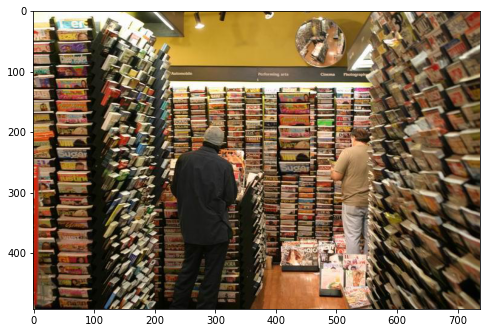

In [49]:
tampered1=cv2.imread(tampered_images[0])
plot_image(tampered1)

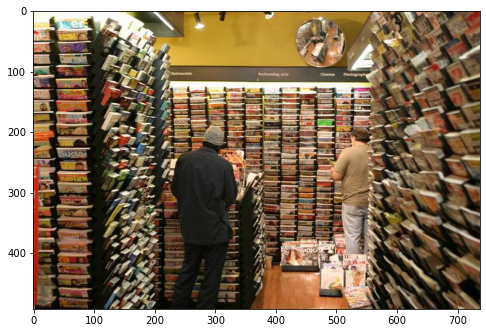

In [50]:
original1 , index=get_original(tampered_images[0])
if index!=-1:
    plot_image(original1)

In [51]:
def make_clusters(de,eps=40,min_sample=2):
    clustering = DBSCAN(eps=eps, min_samples=min_sample).fit(de)
    return clustering


In [52]:

def locate_forgery(img,clustering,kps):
    forgery=img.copy()
    clusters = [[] for i in range(np.unique(clustering.labels_).shape[0]-1)]
    for idx in range(len(kps)):
        if clustering.labels_[idx]!=-1:
            clusters[clustering.labels_[idx]].append((int(kps[idx].pt[0]),int(kps[idx].pt[1])))
    for points in clusters:
        if len(points)>1:
            for idx1 in range(len(points)):
                for idx2 in range(idx1+1,len(points)):
                    cv2.line(forgery,points[idx2],points[idx2],(255,0,0),5)
                    cv2.line(forgery,points[idx1],points[idx1],(255,0,0),5)
    plot_image(forgery)

Let's check if we are able to detect forgery.

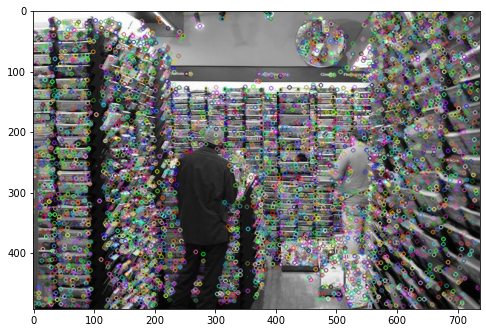

In [53]:
#Firs let us extract SIFT features
key_points,descriptors=siftDetector(tampered1)
show_sift_features(tampered1,key_points)

# Extracting the Exact Key pointsting 

In [83]:

def locate_forgery(img,clustering,kps):
    forgery=img.copy()
    clusters = [[] for i in range(np.unique(clustering.labels_).shape[0]-1)]
    for idx in range(len(kps)):
        if clustering.labels_[idx]!=-1:
            clusters[clustering.labels_[idx]].append((int(kps[idx].pt[0]),int(kps[idx].pt[1])))
    print(clusters)
    for points in clusters:
        if len(points)>1:
            for idx1 in range(len(points)):
                for idx2 in range(idx1+1,len(points)):
                    cv2.line(forgery,points[idx2],points[idx2],(255,255,0),5)
                    cv2.line(forgery,points[idx1],points[idx1],(255,255,0),5)
    
    print()

    plot_image(forgery)

[[(52, 205), (419, 228)], [(53, 126), (420, 149)], [(54, 232), (421, 255)], [(55, 200), (422, 223)], [(56, 179), (423, 202)], [(61, 140), (428, 163)], [(65, 173), (432, 196)], [(65, 231), (432, 254)], [(67, 193), (434, 216)], [(69, 223), (436, 246)], [(69, 200), (436, 223)], [(70, 210), (437, 233)], [(76, 173), (443, 197)], [(79, 125), (446, 148)]]



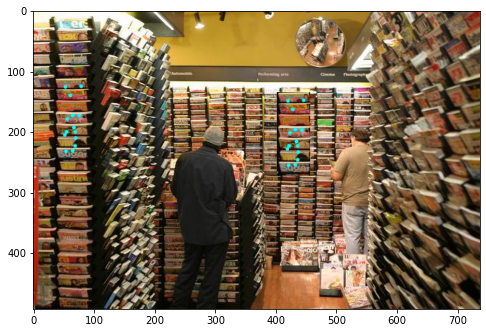

In [84]:

clusters=make_clusters(descriptors)
locate_forgery(tampered1,clusters,key_points)

In [89]:
#finding the CMFD

In [90]:

def locate_forgery(img,clustering,kps):
    forgery=img.copy()
    clusters = [[] for i in range(np.unique(clustering.labels_).shape[0]-1)]
    for idx in range(len(kps)):
        if clustering.labels_[idx]!=-1:
            clusters[clustering.labels_[idx]].append((int(kps[idx].pt[0]),int(kps[idx].pt[1])))
    print(clusters)
    for points in clusters:
        if len(points)>1:
            for idx1 in range(len(points)):
                for idx2 in range(idx1+1,len(points)):
                    cv2.line(forgery,points[idx2],points[idx1],(255,255,0),5)
    
    print()

    plot_image(forgery)

[[(52, 205), (419, 228)], [(53, 126), (420, 149)], [(54, 232), (421, 255)], [(55, 200), (422, 223)], [(56, 179), (423, 202)], [(61, 140), (428, 163)], [(65, 173), (432, 196)], [(65, 231), (432, 254)], [(67, 193), (434, 216)], [(69, 223), (436, 246)], [(69, 200), (436, 223)], [(70, 210), (437, 233)], [(76, 173), (443, 197)], [(79, 125), (446, 148)]]



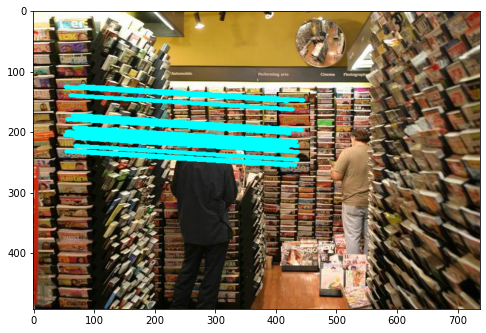

In [91]:

clusters=make_clusters(descriptors)
locate_forgery(tampered1,clusters,key_points)